In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Введение

В общем случае, если вы агрегируете предсказания от нескольких предсказателей, то их агрегированный ответ окажется лучше предсказанного одним оценщиком. В таком случае группа предсказателей называется **ансамблем**, а сама техника - **ансамблевым обучением**. 

Самые популярные методы ансамблевого обучения являются **бэггинг**, **бустинг** и **стеккинг**.

# Голосующие классификаторы

Предположим, мы тренируем множество классификаторов, имеющих какую-либо среднюю точность прогнозов.

Каждый из таких прогнозаторов может составлять свои собственные прогнозы на переданных данных.

Тогда самый простой способ создать лучший классификатор - агрегировать предсказания каждого классификатора в отдельности и предсказать классы для входных данных на основе наибольшего количества голосов. Такой метод классификации называется методом **жесткого голосования** (**hard voting**).

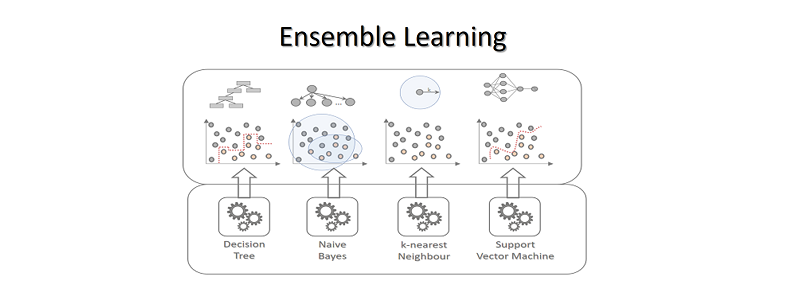

In [2]:
from IPython.display import Image
Image(data='ensemble_learning.png')

Фактически, если даже ансамбль состоит из **слабых учеников** (т.е. классификаторы, которые немного лучше случайных), то он будет представлять из себя **сильного ученика** (достигающего высокой точности прогнозирования), состояющего из достаточного количества слабых, но разнообразных классификаторов.

Разнообразие и независимость классификаторов крайне важны! Всё дело в том, что только независимые и разные классификаторы способны совершать разнообразные некореллируемые ошибки. Это довольно логично: представим, что на одних и тех же данных мы обучим одни и те же классификаторы. Тогда такой набор предсказателей будет совершать однотипные ошибки, тем самым сильно понижая точность всего ансамбля, ведь совершать ошибки они будут на одних и тех же образцах.

В реализации **sklearn** можно предсказывать всем ансамблем не только целевой класс, но и вероятность определенного класса с помощью метода **predict_proba()**. Однако, это возможно только если все оценщики в ансамбле имеют метод **predict_proba()**. В таком случае sklearn будет предсказывать целевой класс тот, средняя вероятность которого выше всех остальных классов. Такой метод предсказания называется **мягкое голосование (soft voting)**. Обычно мягкое голосование достигает точности выше, чем жесткое.

В Sklearn ансамбль на основе голосования можно построить с помощью класса **VotingClassifier**. А чтобы сделать голосование мягким, достаточно изменить параметр **voting='hard'** на **voting='soft'**, но только в том случае, если все классификаторы имеют метод predict_proba().

In [199]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=700, noise=0.3)

Теперь давайте посмотрим какова будет точность отдельных классификатор и всего ансамбля на датасете **полукругов**. 

Разделяем датасет на тренировочный и тестовый наборы данных.

In [212]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Импортируем необходимые оценщики: **SVM**, **Случайный лес** и **Логистическую регрессию** на основе стохастического градиентного спуска.

In [242]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import f1_score

In [243]:
svm = SVC()
svm.fit(X_train, y_train)

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

sgd = SGDClassifier(loss='log')
sgd.fit(X_train, y_train)

SGDClassifier(loss='log')

In [244]:
f1_score(y_test, svm.predict(X_test), average='weighted')

0.9142857142857143

In [245]:
f1_score(y_test, forest.predict(X_test), average='weighted')

0.9071665754424374

In [246]:
f1_score(y_test, sgd.predict(X_test), average='weighted')

0.8429212958912897

In [247]:
voting = VotingClassifier([
    ('log', SGDClassifier(loss='log')),
    ('forest', RandomForestClassifier()),
    ('svm', SVC(probability=True))
], voting='hard')

voting.fit(X_train, y_train)

VotingClassifier(estimators=[('log', SGDClassifier(loss='log')),
                             ('forest', RandomForestClassifier()),
                             ('svm', SVC(probability=True))])

In [248]:
f1_score(y_test, voting.predict(X_test), average='weighted')

0.9071665754424374

В общем случае, как можно заметить, точность ансамбля обычно выше отдельных классификаторов, но это не всегда так.

Заявлять, что ансамблевое обучение всегда лучше - совсем неверно. Есть мнение, что когда ансамбль состоит из моделей, склонных к переобучению, а то есть имеющих большую дисперсию, то следует предпочесть **бэггинг**. Однако, если модели в ансамбле склонны к смещению, то стоит предпочесть **бустинг**.

Из-за неправильного выбора моделей, а также метода ансамблевого обучения, ваш ансамбль не всегда будет лучше отдельно взятой модели. Тут нужно подбирать, сравнивать и смотреть на практике для каждого отдельного случая.

Бэггинг, бустинг и т.п. будет рассмотрен далее.

# Бэггинг